In [1]:
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KernelDensity

In [2]:
real = pd.read_pickle('../data_geolife/geolife_cut.pkl')
fake = pd.read_pickle('../machine_learning/generated/citybased_gan_2/g_GRU-32_rand-32_Dense-3_adam_bce_default_d_gin_GRU-16_Dense-1_adam_bce_default_geolife_64_100_cut.pkl')

In [9]:
fake.head()

longitude   latitude
user time                                                
0    2008-09-29 17:01:14.873175343  116.372880  39.957184
     2008-09-29 17:15:46.589843750  112.699394  41.676441
     2008-09-29 17:39:22.296875000  109.398132  44.199055
     2008-09-29 18:00:23.515625000  100.777153  46.651741
     2008-09-29 18:12:42.031250000   97.351891  47.408810

In [10]:
fake.mean()

longitude    -8.742581
latitude     42.828470
dtype: float64

In [3]:
# Load the OSMNX graphs
streets_beijing = ox.load_graphml('beijing_streets_all.graphml', folder='../osmnx_data')

## Simple overview (small map)

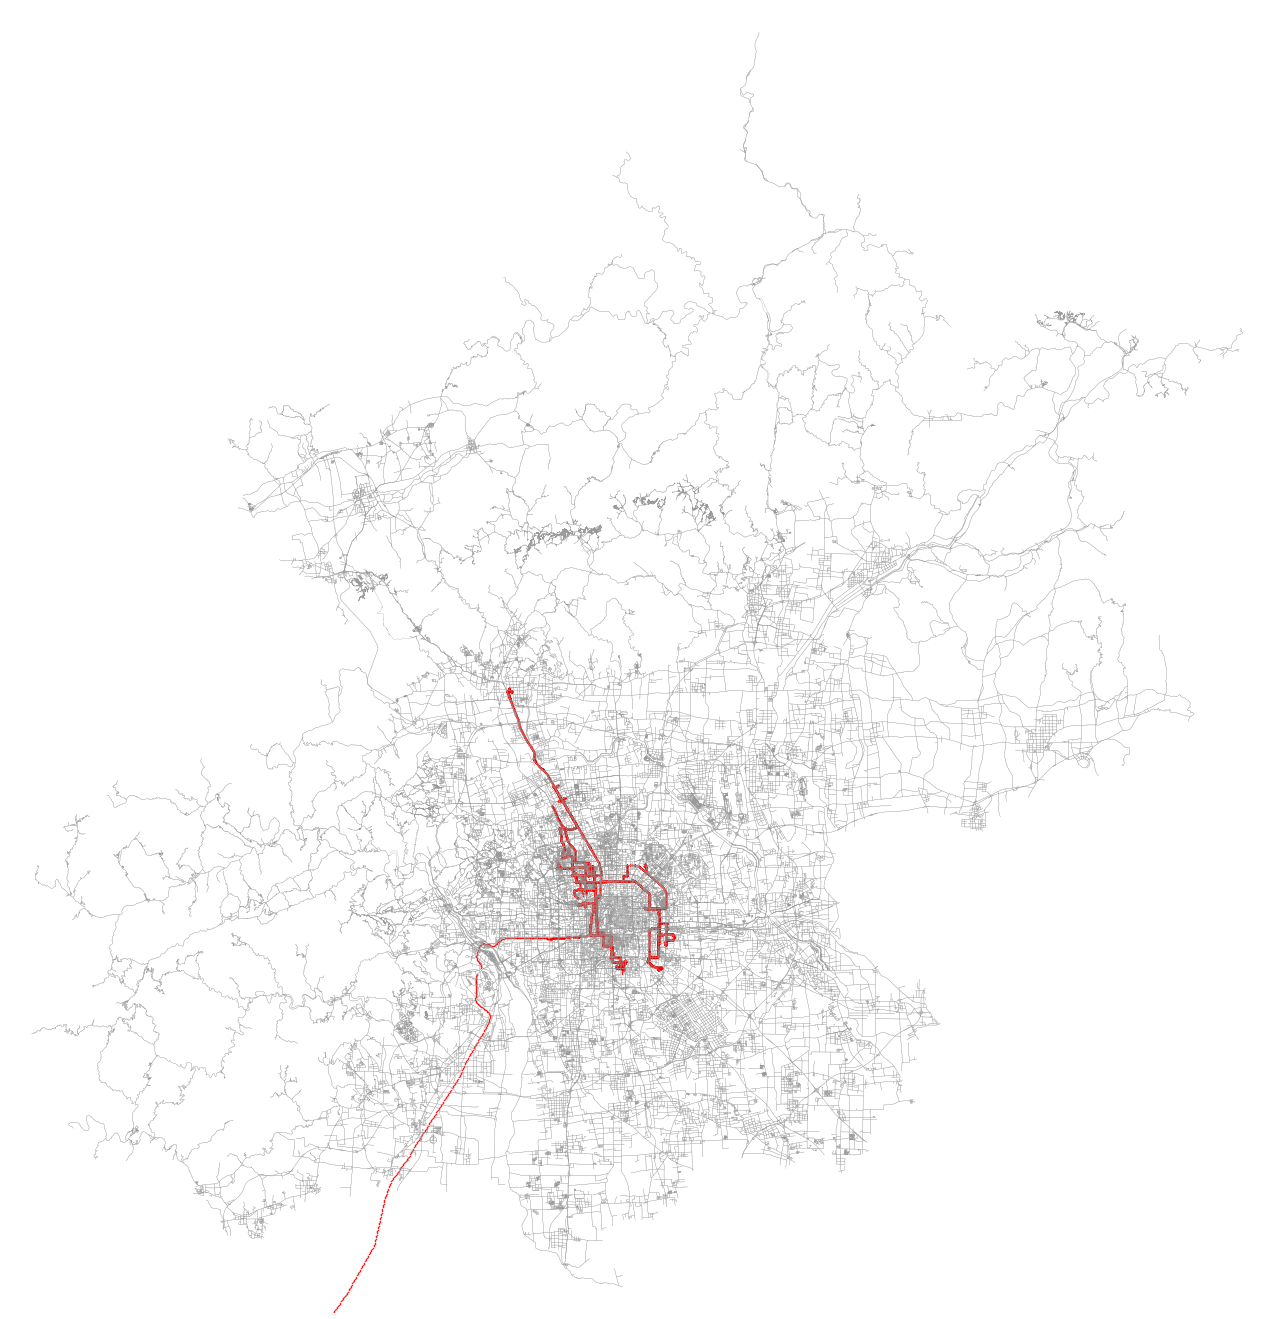

In [6]:
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(real['longitude'], real['latitude'], c='#ff0000', s=0.25, alpha=1.0)

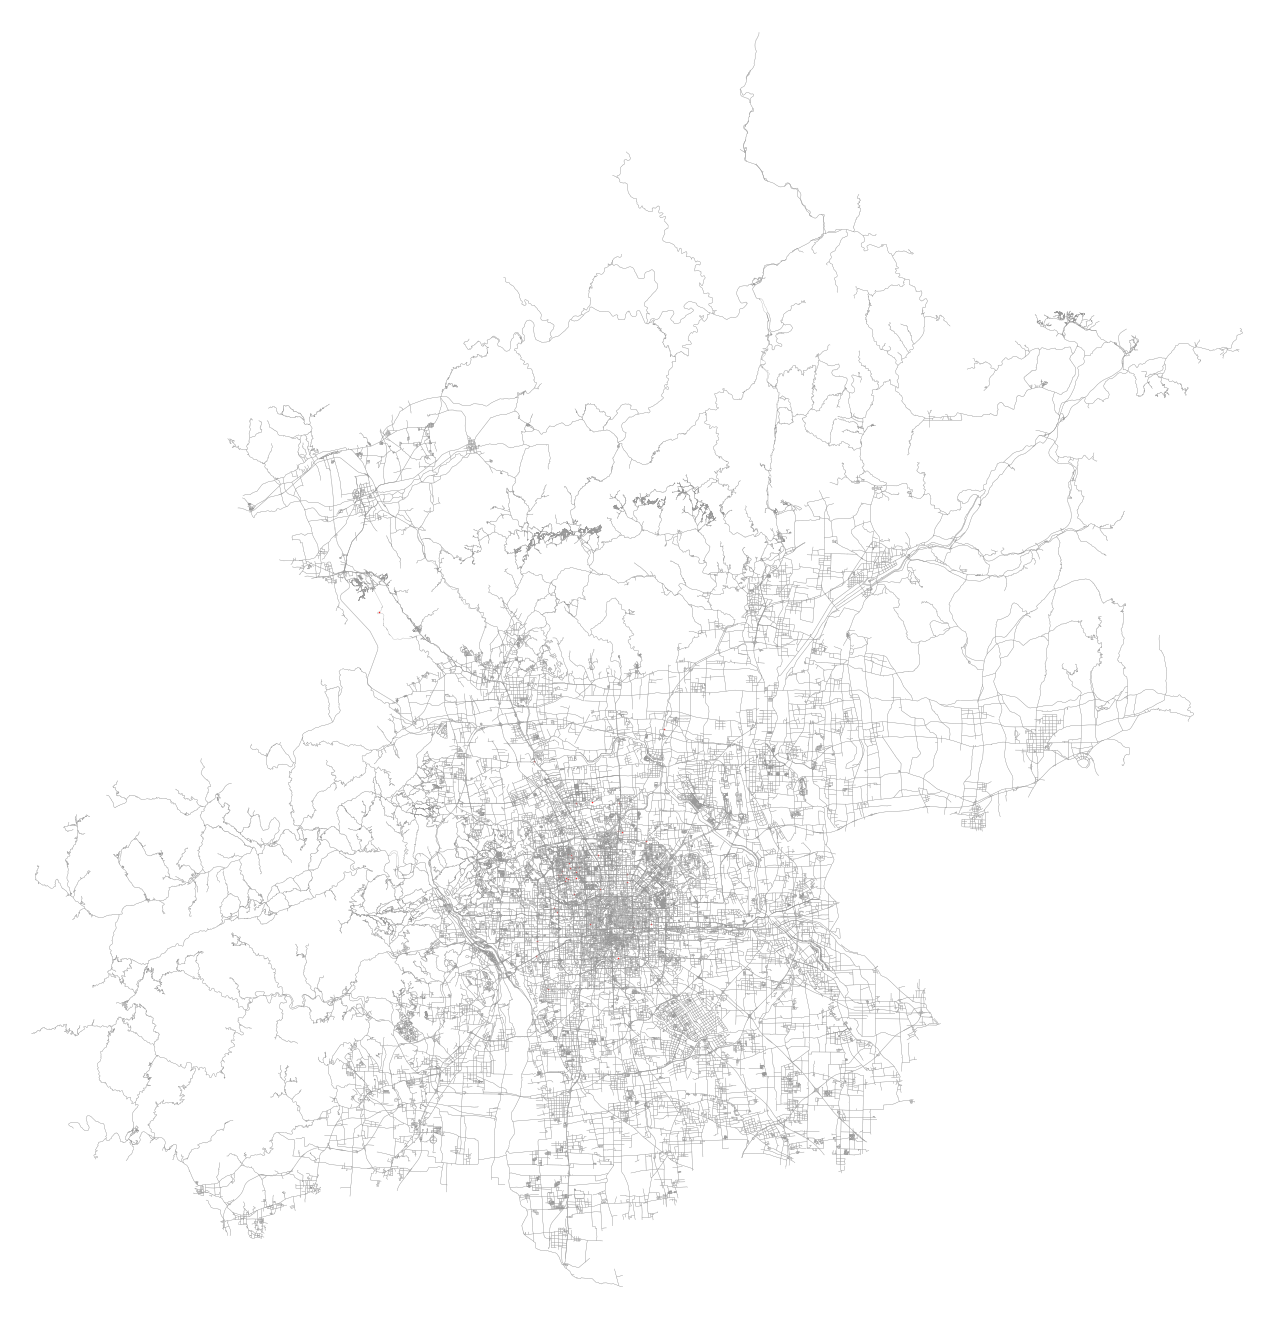

In [4]:
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(fake['longitude'], fake['latitude'], c='#ff0000', s=0.25, alpha=1.0)

## Histogram of # records in every hour

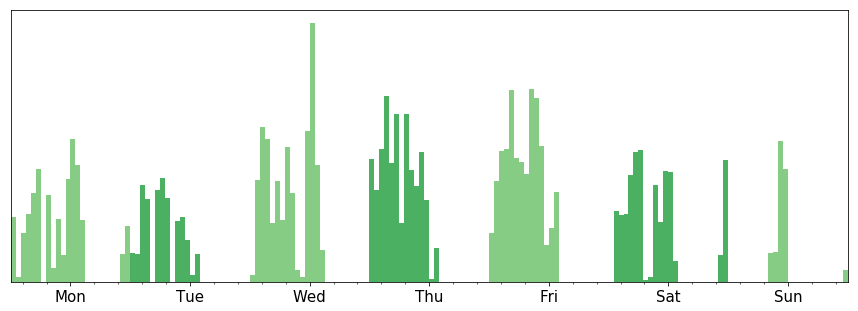

In [3]:
plt.figure(figsize=(15, 5))
_, _, patches = plt.hist(real.index.levels[1], bins=168,
                         range=(pd.Timestamp('2008-09-29 00:00:00'), pd.Timestamp('2008-10-05 23:59:59')))
cm = plt.cm.Greens
colours = ([0.45]*24 + [0.6]*24)*7
for c, p in zip(colours, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlim(pd.Timestamp('2008-09-29 00:00:00'), pd.Timestamp('2008-10-05 23:59:59'))
plt.xticks([pd.Timestamp('2008-09-29 12:00:00'), pd.Timestamp('2008-09-30 12:00:00'),
           pd.Timestamp('2008-10-01 12:00:00'), pd.Timestamp('2008-10-02 12:00:00'),
           pd.Timestamp('2008-10-03 12:00:00'), pd.Timestamp('2008-10-04 12:00:00'),
           pd.Timestamp('2008-10-05 12:00:00')], 
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.minorticks_on()
plt.tick_params(labelsize=15.0)
plt.show()

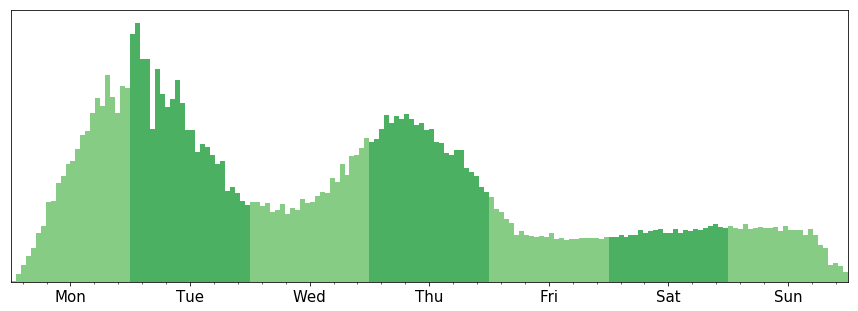

In [4]:
plt.figure(figsize=(15, 5))
_, _, patches = plt.hist(fake.index.levels[1], bins=168,
                         range=(pd.Timestamp('2008-09-29 00:00:00'), pd.Timestamp('2008-10-05 23:59:59')))
cm = plt.cm.Greens
colours = ([0.45]*24 + [0.6]*24)*7
for c, p in zip(colours, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlim(pd.Timestamp('2008-09-29 00:00:00'), pd.Timestamp('2008-10-05 23:59:59'))
plt.xticks([pd.Timestamp('2008-09-29 12:00:00'), pd.Timestamp('2008-09-30 12:00:00'),
           pd.Timestamp('2008-10-01 12:00:00'), pd.Timestamp('2008-10-02 12:00:00'),
           pd.Timestamp('2008-10-03 12:00:00'), pd.Timestamp('2008-10-04 12:00:00'),
           pd.Timestamp('2008-10-05 12:00:00')], 
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.yticks([])
plt.minorticks_on()
plt.tick_params(labelsize=15.0)
plt.show()

## Distribution of speeds

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles * 1.6

def speed_distribution(ds):
    tmp = ds.reset_index()
    delta_t = tmp.groupby('user')['time'].diff().dt.total_seconds()
    delta_t = delta_t / 3600.0
    prvs_poss = tmp.groupby('user')[['latitude', 'longitude']].shift(1)
    delta_w = haversine(prvs_poss['latitude'], prvs_poss['longitude'], tmp['latitude'], tmp['longitude'])
    speeds = delta_w / delta_t
    
    print(speeds.describe())
    
    plt.figure(figsize=(15, 5))
    plt.hist(speeds, bins=range(0, 150))
    plt.xlim(0, 150)
    plt.yticks([])
    plt.minorticks_on()
    plt.tick_params(labelsize=15.0)
    plt.show()

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    9.172000e+04
mean              inf
std               NaN
min      0.000000e+00
25%      3.069942e+00
50%      7.043643e+00
75%      2.747174e+01
max               inf
dtype: float64


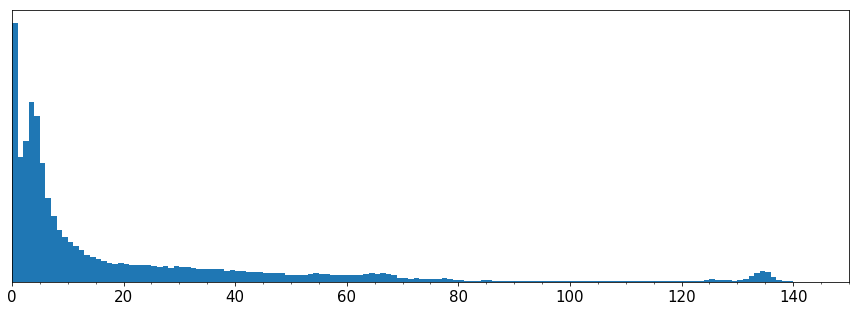

In [4]:
speed_distribution(real)

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    13742.000000
mean      1557.437799
std       5481.726516
min          0.294627
25%         36.517779
50%         93.350049
75%        641.814864
max      87297.106426
dtype: float64


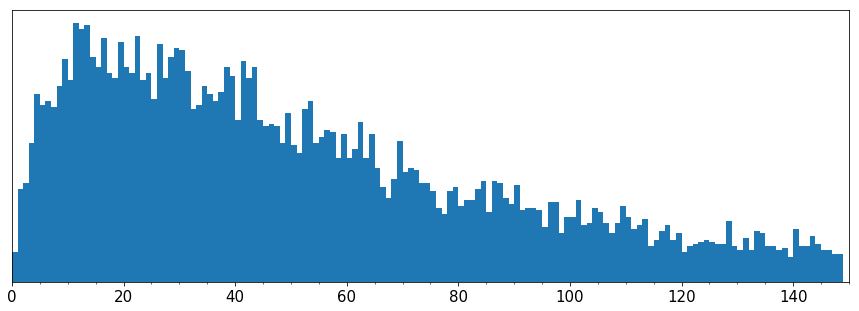

In [5]:
speed_distribution(fake)

## One user's data

In [14]:
real.index.levels[0]

Int64Index([11, 13, 62, 84, 96, 153], dtype='int64', name='user')

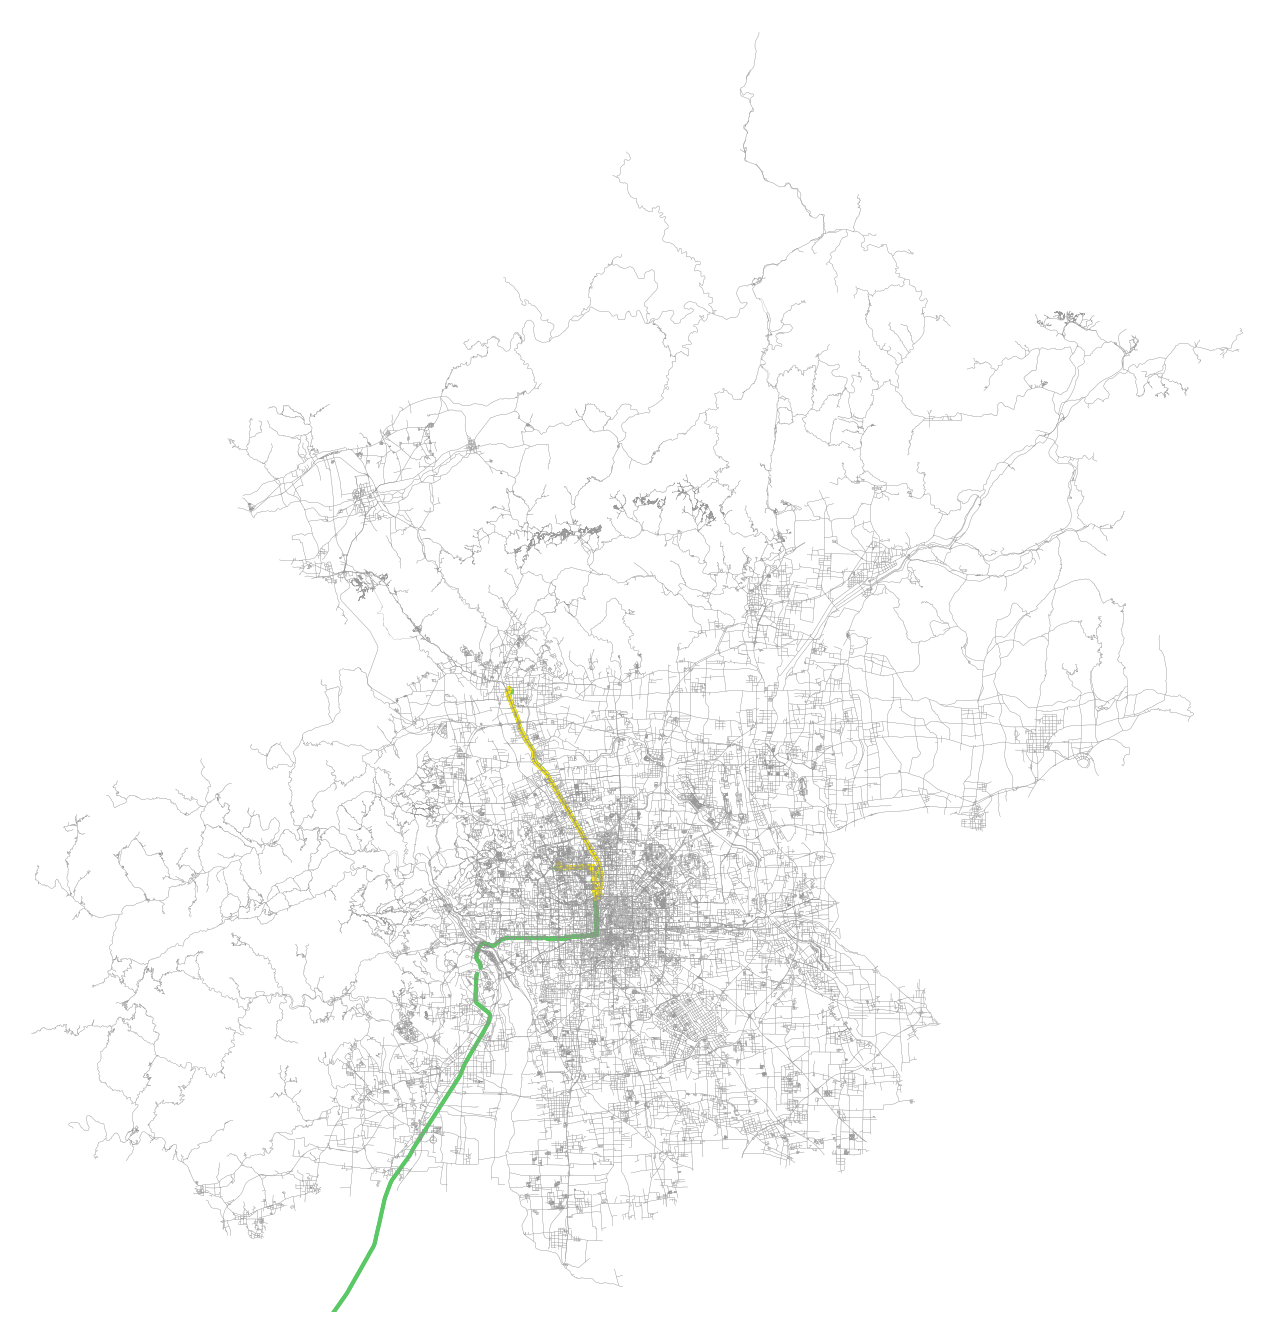

In [19]:
user = 62
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(real.loc[user]['longitude'], real.loc[user]['latitude'], c=real.loc[user].index, s=10.0, alpha=1.0)

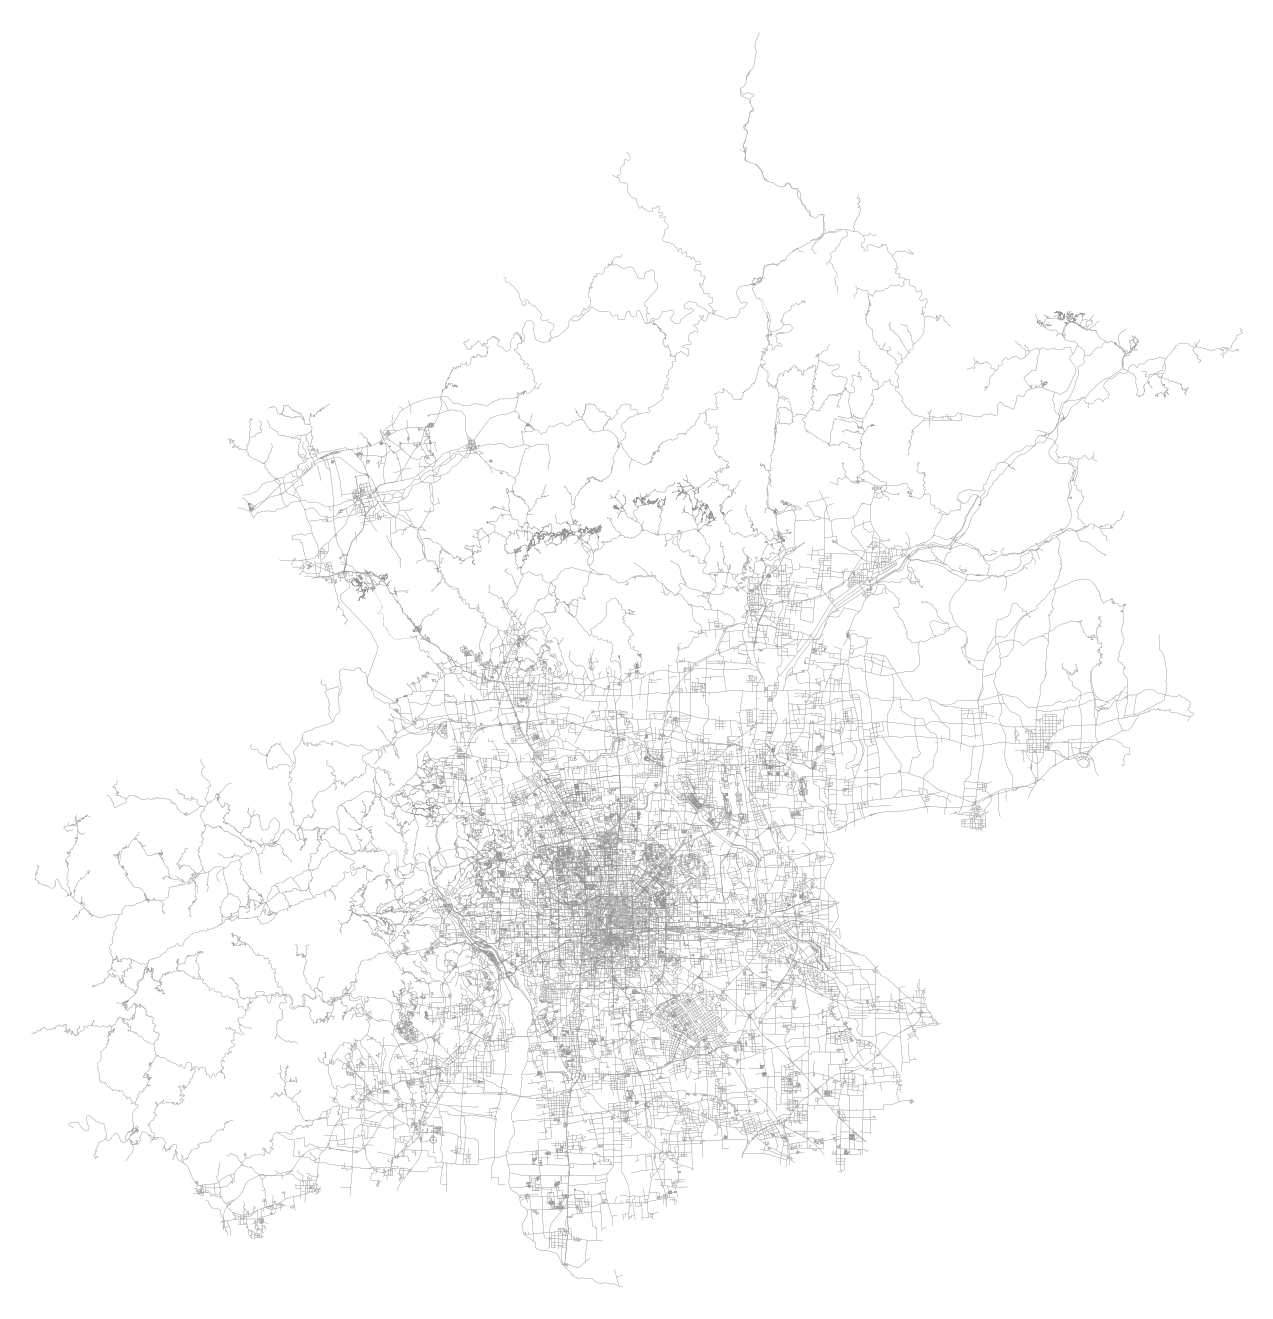

In [8]:
user = 4
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(fake.loc[user]['longitude'], fake.loc[user]['latitude'], c=fake.loc[user].index, s=10.0, alpha=1.0)